# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.



# Инструкция по выполнению проекта

Загрузите и подготовьте данные. Поясните порядок действий.
Исследуйте баланс классов, обучите модель без учёта дисбаланса. Кратко опишите выводы.
Улучшите качество модели, учитывая дисбаланс классов. Обучите разные модели и найдите лучшую. Кратко опишите выводы.
Проведите финальное тестирование.
Описание данных
Данные находятся в файле /datasets/Churn.csv



# Признаки

RowNumber — индекс строки в данных  
CustomerId — уникальный идентификатор клиента  
Surname — фамилия  
CreditScore — кредитный рейтинг  
Geography — страна проживания  
Gender — пол  
Age — возраст  
Tenure — сколько лет человек является клиентом банка  
Balance — баланс на счёте  
NumOfProducts — количество продуктов банка, используемых клиентом  
HasCrCard — наличие кредитной карты  
IsActiveMember — активность клиента  
EstimatedSalary — предполагаемая зарплата  

Целевой признак    
Exited — факт ухода клиента  



## Подготовка данных

Импортируем необходимые библиотеки

In [50]:
import pandas as pd
import seaborn as sbn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,roc_auc_score,f1_score,precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve 
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import GradientBoostingClassifier

Уберем экспонентациальные формы при выводе данных

In [2]:
pd.set_option('display.float_format', '{:,.2f}'.format)

Сбросим ограничение на количество выводимых столбцов, что бы просмотреть все столбцы

In [3]:
pd.set_option('display.max_columns', None)

Чтобы предупреждение SettingWithCopy не появлялось добавим строчку кода

In [4]:
pd.options.mode.chained_assignment = None

Чтение файла с данными и сохранение в DataFrame

In [5]:
try:
    df = pd.read_csv('C:/Users/КоньковаМария/Desktop/git/Churn.csv')
except:
    df = pd.read_csv('/datasets/Churn.csv')

Посмотрим на первые 5 строк таблицы df

In [6]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.00,0.00,1,1,1,"101,348.88",1
1,2,15647311,Hill,608,Spain,Female,41,1.00,"83,807.86",1,0,1,"112,542.58",0
2,3,15619304,Onio,502,France,Female,42,8.00,"159,660.80",3,1,0,"113,931.57",1
3,4,15701354,Boni,699,France,Female,39,1.00,0.00,2,0,0,"93,826.63",0
4,5,15737888,Mitchell,850,Spain,Female,43,2.00,"125,510.82",1,1,1,"79,084.10",0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Заметил следующее:  
Пропуски в столбце Tenure;  
Ненужные столбцы RowNumber, CustomerId, Surname;  
Категориальные признаки - столбцы Geography и Gender

Заменим пропуски на 0

In [8]:
df['Tenure'] = df['Tenure'].fillna(df['Tenure'].median())

Удалим ненужные столбцы

In [9]:
df.drop(['RowNumber', 'CustomerId', 'Surname'], axis='columns', inplace=True)

Задействуем технику прямого кодирования, чтобы преобразовать категориальные признаки в численные.

In [10]:
df = pd.get_dummies(df, drop_first=True)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        10000 non-null  int64  
 1   Age                10000 non-null  int64  
 2   Tenure             10000 non-null  float64
 3   Balance            10000 non-null  float64
 4   NumOfProducts      10000 non-null  int64  
 5   HasCrCard          10000 non-null  int64  
 6   IsActiveMember     10000 non-null  int64  
 7   EstimatedSalary    10000 non-null  float64
 8   Exited             10000 non-null  int64  
 9   Geography_Germany  10000 non-null  uint8  
 10  Geography_Spain    10000 non-null  uint8  
 11  Gender_Male        10000 non-null  uint8  
dtypes: float64(3), int64(6), uint8(3)
memory usage: 732.5 KB


In [12]:
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.00,0.00,1,1,1,"101,348.88",1,0,0,0
1,608,41,1.00,"83,807.86",1,0,1,"112,542.58",0,0,1,0
2,502,42,8.00,"159,660.80",3,1,0,"113,931.57",1,0,0,0
3,699,39,1.00,0.00,2,0,0,"93,826.63",0,0,0,0
4,850,43,2.00,"125,510.82",1,1,1,"79,084.10",0,0,1,0


Изучим корреляции в данных. Так мы сможем оценить взаимосвязи в данных и влияние параметров на целевой признак.

In [13]:
sbn.pairplot(df, hue = 'Exited')
plt.show()

## Исследование задачи

Разобьем данные на выборки

In [14]:
target=df['Exited'] 
features=df.drop(['Exited'],axis=1) 

In [15]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.40, random_state=12345
)
features_test, features_valid, target_test, target_valid = train_test_split(
    features_test, target_test, test_size=0.50, random_state=12345
)

In [16]:
print('Разделение выборки в следующих пропорциях:')
print(f'{(len(features_train)/len(df)):.0%} — тренировочная;')
print(f'{(len(features_test)/len(df)):.0%} — тестовая;')
print(f'{(len(features_valid)/len(df)):.0%} — валидационная.')

Разделение выборки в следующих пропорциях:
60% — тренировочная;
20% — тестовая;
20% — валидационная.


Масштабируем признаки методом стандартизации

In [17]:
numeric = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'Tenure', 'NumOfProducts']

In [18]:
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

Посмотрим количество объектов отрицательного и положительно класса

In [19]:
features[target == 0].shape, features[target == 1].shape

((7963, 11), (2037, 11))

Наблюдается дисбаланс классов, объектов отрицаткльного класса почти в 4 раза больше , чем объектов положительного. Рассчитаем базовые модели на несбалансированных данных.

Построим модели без учета баланса

Функция для показа метрик

In [20]:
def show_metrics(model, features, target, model_name):
    predictions = model.predict(features)
    probabilities = model.predict_proba(features)[:, 1]
    metrics = {
        'F1-мера': [f'{f1_score(target, predictions):.2%}'],
        'Полнота (recall)': [f'{recall_score(target, predictions):.2%}'],
        'AUC-ROC метрика': [f'{roc_auc_score(target, probabilities):.2%}'],
        'Точность (precision)': [f'{precision_score(target, predictions):.2%}'],
        'Доля правильных ответов (accuracy)': [f'{accuracy_score(target, predictions):.2%}'],
    }
    df_metrics = pd.DataFrame.from_dict(metrics, orient='index')
    df_metrics = df_metrics.rename(columns={0: model_name})
    display(df_metrics)

Обучение с помощью модели Дерева решения

In [21]:
best_depth = 0
best_f1 = 0
for depth in range(1,10,1):
    model_tree=DecisionTreeClassifier(max_depth=depth,random_state=1234).fit(features_train,target_train)
    predictions_valid=model_tree.predict(features_valid)
    f1 = f1_score(target_valid, predictions_valid)
    if f1 > best_f1:
        best_f1 = f1
        best_depth = depth
print(f'Наилучшая метрика F1: {best_f1:.2%} при глубине {best_depth}')

Наилучшая метрика F1: 52.63% при глубине 9


In [22]:
model = DecisionTreeClassifier(max_depth=best_depth, random_state=12345)
model.fit(features_train, target_train)
show_metrics(model, features_valid, target_valid, 'Дерево решений')

,Дерево решений
F1-мера,52.54%
Полнота (recall),45.15%
AUC-ROC метрика,77.82%
Точность (precision),62.83%
Доля правильных ответов (accuracy),82.75%


Обучение с помощью модели Случайный лес

In [23]:
best_depth = 0
best_est = 0
best_f1 = 0
for est in range(51, 110, 10):
    for depth in range(17, 18):
        model = RandomForestClassifier(n_estimators=est, max_depth=depth, random_state=12345)
        model.fit(features_train, target_train)
        predictions_valid = model.predict(features_valid)
        f1 = f1_score(target_valid, predictions_valid)
        if f1 > best_f1:
            best_f1 = f1
            best_depth = depth
            best_est = est
print(f'Наилучшая метрика F1: {best_f1:.1%} при количестве «деревьев» {best_est} и при глубине {best_depth}')

Наилучшая метрика F1: 52.8% при количестве «деревьев» 81 и при глубине 17


In [24]:
model = RandomForestClassifier(n_estimators=best_est, max_depth=best_depth, random_state=12345)
model.fit(features_train, target_train)
show_metrics(model, features_valid, target_valid, 'Случайный лес')

,Случайный лес
F1-мера,52.79%
Полнота (recall),41.37%
AUC-ROC метрика,85.12%
Точность (precision),72.92%
Доля правильных ответов (accuracy),84.35%


Обучение с помощью модели Логистической регрессии

Рассматривая данные с дисбалансом (но, с переведенными категориальными и стандартизированными данными) тремя моделями можно сделать вывод, что саммая лучшая модель оказалась Случайный лес. При лучшем значении F1: 52.8% при количестве «деревьев» 81 и при глубине 17.

## Борьба с дисбалансом

Параметр class_weight для борьбы с дисбалансом

Начнем с логистической регрессии

In [25]:
model = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=12345)
model.fit(features_train, target_train)
show_metrics(model, features_valid, target_valid, 'Логистическая регрессия')

,Логистическая регрессия
F1-мера,47.88%
Полнота (recall),65.48%
AUC-ROC метрика,74.18%
Точность (precision),37.74%
Доля правильных ответов (accuracy),69.85%


Значение с параметром class_weight, лучше чем без него.

Решающее дерево

In [26]:
best_depth = 0
best_f1 = 0
for depth in range(1, 10):
    model = DecisionTreeClassifier(max_depth=depth, random_state=12345, class_weight='balanced')
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    f1 = f1_score(target_valid, predictions_valid)
    if f1 > best_f1:
        best_f1 = f1
        best_depth = depth
print(f'Наилучшая метрика F1: {best_f1:.1%} при глубине {best_depth}')

Наилучшая метрика F1: 58.1% при глубине 5


In [27]:
model = DecisionTreeClassifier(max_depth=best_depth, random_state=12345, class_weight='balanced')
model.fit(features_train, target_train)
show_metrics(model, features_valid, target_valid, 'Дерево решений')

,Дерево решений
F1-мера,58.09%
Полнота (recall),66.19%
AUC-ROC метрика,83.55%
Точность (precision),51.76%
Доля правильных ответов (accuracy),79.80%


Случайный лес

In [28]:
best_depth = 0
best_est = 0
best_f1 = 0
for est in range(51, 110, 10):
    for depth in range(8, 9):
        model = RandomForestClassifier(n_estimators=est, max_depth=depth, random_state=12345, class_weight='balanced')
        model.fit(features_train, target_train)
        predictions_valid = model.predict(features_valid)
        f1 = f1_score(target_valid, predictions_valid)
        if f1 > best_f1:
            best_f1 = f1
            best_depth = depth
            best_est = est
print(f'Наилучшая метрика F1: {best_f1:.1%} при количестве «деревьев» {best_est} и при глубине {best_depth}')

Наилучшая метрика F1: 61.3% при количестве «деревьев» 71 и при глубине 8


In [29]:
model = RandomForestClassifier(n_estimators=best_est, max_depth=best_depth, random_state=12345, class_weight='balanced')
model.fit(features_train, target_train)
show_metrics(model, features_valid, target_valid, 'Случайный лес')

,Случайный лес
F1-мера,61.34%
Полнота (recall),67.14%
AUC-ROC метрика,85.52%
Точность (precision),56.46%
Доля правильных ответов (accuracy),82.10%


Лучшее значение у модели Случайный лес при max_depth=8 и n_estimators=61 при котором F1=61.57%.  


Увеличение выборки техникой upsampling

In [30]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

Далее обучим логистическую регрессию, дерево решений и случайный лес на признаках увеличенной обучающей выборки, и рассчитаем метрики f1

In [31]:
model = LogisticRegression(solver='liblinear', random_state=12345)
model.fit(features_upsampled, target_upsampled)
show_metrics(model, features_valid, target_valid, 'Логистическая регрессия')

,Логистическая регрессия
F1-мера,47.62%
Полнота (recall),65.01%
AUC-ROC метрика,74.18%
Точность (precision),37.57%
Доля правильных ответов (accuracy),69.75%


In [32]:
best_depth = 0
best_f1 = 0
for depth in range(1, 10):
    model = DecisionTreeClassifier(max_depth=depth, random_state=12345)
    model.fit(features_upsampled, target_upsampled)
    predictions_valid = model.predict(features_valid)
    f1 = f1_score(target_valid, predictions_valid)
    if f1 > best_f1:
        best_f1 = f1
        best_depth = depth
print(f'Наилучшая метрика F1: {best_f1:.1%} при глубине {best_depth}')

Наилучшая метрика F1: 58.1% при глубине 5


In [33]:
model = DecisionTreeClassifier(max_depth=best_depth, random_state=12345)
model.fit(features_upsampled, target_upsampled)
show_metrics(model, features_valid, target_valid, 'Дерево решений')

,Дерево решений
F1-мера,58.09%
Полнота (recall),66.19%
AUC-ROC метрика,83.55%
Точность (precision),51.76%
Доля правильных ответов (accuracy),79.80%


In [34]:
best_depth = 0
best_est = 0
best_f1 = 0
for est in range(51, 110, 101):
    for depth in range(1, 10):
        model = RandomForestClassifier(n_estimators=est, max_depth=depth, random_state=12345)
        model.fit(features_upsampled, target_upsampled)
        predictions_valid = model.predict(features_valid)
        f1 = f1_score(target_valid, predictions_valid)
        if f1 > best_f1:
            best_f1 = f1
            best_depth = depth
            best_est = est
print(f'Наилучшая метрика F1: {best_f1:.1%} при количестве «деревьев» {best_est} и при глубине {best_depth}')

Наилучшая метрика F1: 61.9% при количестве «деревьев» 51 и при глубине 8


In [35]:
model = RandomForestClassifier(n_estimators=best_est, max_depth=best_depth, random_state=12345)
model.fit(features_upsampled, target_upsampled)
show_metrics(model, features_valid, target_valid, 'Случайный лес')

,Случайный лес
F1-мера,61.90%
Полнота (recall),72.58%
AUC-ROC метрика,85.79%
Точность (precision),53.95%
Доля правильных ответов (accuracy),81.10%


Лучшее значение с техникой upsampling у модели Случайный лес с F1: 61.9% при количестве «деревьев» 51 и при глубине 8

Уменьшение выборки техникой downsampling 

In [36]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)


Далее обучим логистическую регрессию, дерево решений и случайный лес на признаках уменьшенной обучающей выборки, и рассчитаем метрики f1

In [37]:
model = LogisticRegression(solver='liblinear', random_state=12345)
model.fit(features_downsampled, target_downsampled)
show_metrics(model, features_valid, target_valid, 'Логистическая регрессия')

,Логистическая регрессия
F1-мера,48.42%
Полнота (recall),66.90%
AUC-ROC метрика,74.13%
Точность (precision),37.94%
Доля правильных ответов (accuracy),69.85%


In [38]:
best_depth = 0
best_f1 = 0
for depth in range(1, 10):
    model = DecisionTreeClassifier(max_depth=depth, random_state=12345)
    model.fit(features_downsampled, target_downsampled)
    predictions_valid = model.predict(features_valid)
    f1 = f1_score(target_valid, predictions_valid)
    if f1 > best_f1:
        best_f1 = f1
        best_depth = depth
print(f'Наилучшая метрика F1: {best_f1:.1%} при глубине {best_depth}')

Наилучшая метрика F1: 60.8% при глубине 5


In [39]:
model = DecisionTreeClassifier(max_depth=best_depth, random_state=12345)
model.fit(features_downsampled, target_downsampled)
show_metrics(model, features_valid, target_valid, 'Дерево решений')

,Дерево решений
F1-мера,60.81%
Полнота (recall),69.50%
AUC-ROC метрика,83.78%
Точность (precision),54.04%
Доля правильных ответов (accuracy),81.05%


In [40]:
best_depth = 0
best_est = 0
best_f1 = 0
for est in range(51, 110, 10):
    for depth in range(6, 7):
        model = RandomForestClassifier(n_estimators=est, max_depth=depth, random_state=12345)
        model.fit(features_downsampled, target_downsampled)
        predictions_valid = model.predict(features_valid)
        f1 = f1_score(target_valid, predictions_valid)
        if f1 > best_f1:
            best_f1 = f1
            best_depth = depth
            best_est = est
print(f'Наилучшая метрика F1: {best_f1:.1%} при количестве «деревьев» {best_est} и при глубине {best_depth}')

Наилучшая метрика F1: 58.7% при количестве «деревьев» 101 и при глубине 6


In [41]:
model = RandomForestClassifier(n_estimators=best_est, max_depth=best_depth, random_state=12345)
model.fit(features_downsampled, target_downsampled)
show_metrics(model, features_valid, target_valid, 'Случайный лес')

,Случайный лес
F1-мера,58.71%
Полнота (recall),74.47%
AUC-ROC метрика,84.53%
Точность (precision),48.46%
Доля правильных ответов (accuracy),77.85%


Лучшее значение с техникой downsampling у модели Дерево решений с F1: 60.8% при глубине 5

Вывод  
Из результатов по борьбе дисбаланса классов следует что наибольше значения метрики f1 получили при применении техники upsampling у модели Случайный лес с F1: 61.9% при количестве «деревьев» 51 и при глубине 8.


## Тестирование модели

### Формирование финальной модели

Финальная модель — «Случайный лес».  
Которая показала наилучшую метрику F1:61.9%  
При количестве «деревьев» 51  
При глубине 8.

In [42]:
final_model = RandomForestClassifier(n_estimators=51, max_depth=8, random_state=12345)
final_model.fit(features_upsampled, target_upsampled)
show_metrics(final_model, features_valid, target_valid, 'Случайный лес')

,Случайный лес
F1-мера,61.90%
Полнота (recall),72.58%
AUC-ROC метрика,85.79%
Точность (precision),53.95%
Доля правильных ответов (accuracy),81.10%


Тестирование финальной модели

In [43]:
show_metrics(final_model, features_test, target_test, 'Финальная модель')

,Финальная модель
F1-мера,62.34%
Полнота (recall),71.29%
AUC-ROC метрика,85.44%
Точность (precision),55.39%
Доля правильных ответов (accuracy),82.00%


In [44]:
target_constraint = pd.Series([0]*len(target_valid))
final_predictions = final_model.predict(features_valid)
final_probabilities = final_model.predict_proba(features_valid)[:, 1]
print(f'Точность константной модели: {accuracy_score(target_valid, target_constraint):.0%}')
print(f'Точность финальной модели: {accuracy_score(target_valid, final_predictions):.0%}')
print(f'AUC-ROC метрика константной модели: {roc_auc_score(target_valid, target_constraint):.0%}')
print(f'AUC-ROC метрика финальной модели: {roc_auc_score(target_valid, final_probabilities):.0%}')

Точность константной модели: 79%
Точность финальной модели: 81%
AUC-ROC метрика константной модели: 50%
AUC-ROC метрика финальной модели: 86%


Точность финальной модели выше константной, можно считать финальную модель «рабочей».

Построим ROC-кривую

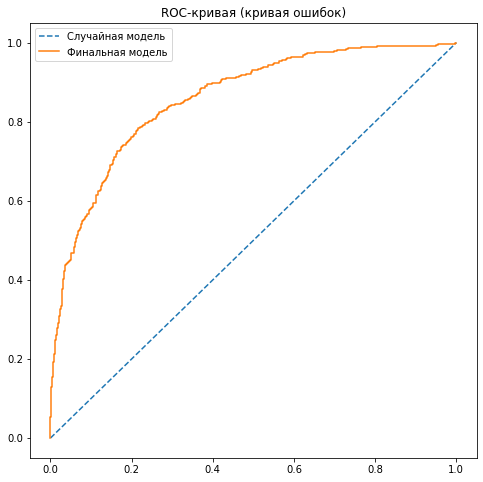

In [45]:
probabilities_valid = final_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
plt.figure(figsize=(8, 8))
plt.title('ROC-кривая (кривая ошибок)')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)
plt.legend(('Случайная модель', 'Финальная модель'))
plt.show()

## Вывод  
Ознакомились с данными и подготовили их к исследованию (преобразовали категориальные признаки в численные с помощью техники прямого кодирования One-Hot Encoding, масштабировали признаки методом стандартизации).  
Исследовали баланс классов - они оказались несбалансированы, изучили модели без учёта дисбаланса, выяснили, что саммая лучшая модель оказалась Случайный лес. При лучшем значении F1: 52.8% при количестве «деревьев» 81 и при глубине 17. 
Применили 3 способа борьбы с дисбалансом - аргумент class_weight, уменьшение выборки и увеличение выборки. Лучшие результаты показал способы борьбы с дисбалансом получили при применении техники upsampling у модели Случайный лес с F1: 61.9% при количестве «деревьев» 51 и при глубине 8, что больше чем заданное по проекту 0,59.  
AUC-ROC метрика финальной модели — 86% — сильно выше показателя случайной модели. Точность финальной модели выше константной, можно считать финальную модель «рабочей».
